<a href="https://colab.research.google.com/github/atkachyshyn123/Thesis/blob/main/Thesis_comparative_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Coreset Selection Herding


In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from datetime import datetime
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, TensorDataset
import glob
from types import SimpleNamespace
import time

# Define a custom ImageNet subset dataset class
class CustomImageNetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = os.path.expanduser(root)
        self.transform = transform

        # Load data - assuming a directory structure where each class has its own folder
        self.image_paths, self.labels = self._load_data()
        self.targets = self.labels  # For compatibility with Herding code

    def _load_data(self):
        """Load data from directory structure."""
        image_paths = []
        labels = []

        # Check if the root is a specific class folder or a parent folder with class subfolders
        if os.path.basename(self.root).startswith('n'):
            # Single class folder
            class_dirs = [self.root]
        else:
            # Multiple class folders
            class_dirs = sorted(glob.glob(os.path.join(self.root, 'n*')))

        print(f"Found {len(class_dirs)} class directories")

        for class_idx, class_dir in enumerate(class_dirs):
            # Look for all image files (JPEG/JPG/PNG)
            for img_ext in ['*.JPEG', '*.jpeg', '*.jpg', '*.JPG', '*.png', '*.PNG']:
                pattern = os.path.join(class_dir, img_ext)
                for img_path in glob.glob(pattern):
                    image_paths.append(img_path)
                    labels.append(class_idx)

        print(f"Found {len(image_paths)} images in total")
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        try:
            with open(image_path, 'rb') as f:
                img = Image.open(f).convert('RGB')

            if self.transform:
                img = self.transform(img)

            return img, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a small blank image in case of error
            dummy_img = torch.zeros(3, 224, 224) if self.transform else Image.new('RGB', (224, 224))
            return dummy_img, label

def euclidean_dist(x, y):
    """
    Compute euclidean distance between two tensors
    """
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

# Simple Herding implementation focused on returning image paths
class Herding:
    def __init__(self, dst_train, args, fraction=0.5, random_seed=None, balance=True, num_images=20):
        self.dst_train = dst_train
        self.args = args
        self.fraction = fraction
        self.num_images_per_class = num_images
        self.balance = balance

        if random_seed is not None:
            self.random_seed = random_seed
        else:
            self.random_seed = int(datetime.now().timestamp() * 1000) % 100000

        torch.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)

        self.n_train = len(dst_train)
        self.metric = euclidean_dist

        # Set up embedding extraction
        self.embedding_dim = 256

    def extract_features(self, data_loader):
        """Extract features directly using a transform-based approach"""
        print("Extracting features...")
        device = self.args.device
        all_features = []
        all_indices = []

        # Use simple mean-based feature extraction
        with torch.no_grad():
            for i, (inputs, _) in enumerate(data_loader):
                if i % 20 == 0:
                    print(f"Processing batch {i}...")

                inputs = inputs.to(device)

                # Simple feature extraction: mean across spatial dimensions
                features = torch.mean(inputs, dim=[2, 3])

                # Ensure we have a 2D tensor
                if features.dim() == 1:
                    features = features.unsqueeze(0)

                # Store features and corresponding indices
                all_features.append(features.cpu())

                # Calculate indices for this batch
                batch_indices = list(range(i * data_loader.batch_size,
                                          min((i + 1) * data_loader.batch_size, len(data_loader.dataset))))
                all_indices.extend(batch_indices)

        # Concatenate all features
        all_features = torch.cat(all_features, dim=0)

        return all_features, all_indices

    def herding(self, features, budget, class_indices=None):
        """Apply herding algorithm to features"""
        if features.shape[0] == 0:
            return np.array([], dtype=np.int32)

        if budget <= 0:
            return np.array([], dtype=np.int32)

        if budget >= features.shape[0]:
            return np.array(range(features.shape[0]), dtype=np.int32)

        # Working indices (relative to the features tensor)
        working_indices = np.arange(features.shape[0])

        # Convert features to device
        features = features.to(self.args.device)

        with torch.no_grad():
            # Compute mean of all features
            mu = torch.mean(features, dim=0)

            # Initialize selection mask
            selected = np.zeros(features.shape[0], dtype=bool)

            # Herding selection
            for i in range(budget):
                if i % 5 == 0:
                    print(f"Selecting {i+1}/{budget}...")

                # Calculate distance from the current mean (scaled by i+1) to unselected features
                dist = self.metric(
                    ((i + 1) * mu - torch.sum(features[selected], dim=0)).unsqueeze(0),
                    features[~selected]
                )

                # Get best match
                p = torch.argmax(dist).item()
                idx_to_select = working_indices[~selected][p]
                selected[idx_to_select] = True

            # Get the original indices if class_indices was provided
            if class_indices is not None:
                selected_orig_indices = [class_indices[i] for i, flag in enumerate(selected) if flag]
                return np.array(selected_orig_indices)
            else:
                return working_indices[selected]

    def select(self):
        """Select representative samples using herding and return image paths"""
        print("Starting image selection process...")
        targets = np.array(self.dst_train.targets)

        # Results to store
        selected_image_paths = {}
        selected_indices = {}
        all_selected_paths = []
        all_selected_indices = []

        # Get unique class labels
        unique_classes = np.unique(targets)
        print(f"Found {len(unique_classes)} classes in the dataset")

        # Process each class separately
        for class_label in unique_classes:
            print(f"\nProcessing class {class_label}...")
            class_indices = np.where(targets == class_label)[0]
            print(f"Class {class_label} has {len(class_indices)} images")

            # Skip if no images
            if len(class_indices) == 0:
                print(f"No images for class {class_label}, skipping")
                continue

            # Handle case where a class has fewer than requested images
            target_size = min(self.num_images_per_class, len(class_indices))
            print(f"Selecting {target_size} images for class {class_label}")

            # Create a subset loader for this class
            subset = torch.utils.data.Subset(self.dst_train, class_indices)
            loader = torch.utils.data.DataLoader(
                subset,
                batch_size=self.args.selection_batch,
                shuffle=False,
                num_workers=self.args.workers
            )

            # Extract features for this class
            features, _ = self.extract_features(loader)

            # Apply herding selection for this class
            selected_idx = self.herding(features, target_size, class_indices)

            # Get image paths for selected indices
            class_paths = [self.dst_train.image_paths[idx] for idx in selected_idx]

            # Store results
            selected_image_paths[int(class_label)] = class_paths
            selected_indices[int(class_label)] = selected_idx.tolist()

            # Add to overall results
            all_selected_paths.extend(class_paths)
            all_selected_indices.extend(selected_idx)

        # Create final result dictionaries with paths emphasized
        result = {
            "image_paths_by_class": selected_image_paths,
            "all_image_paths": all_selected_paths,
            "indices_by_class": selected_indices,
            "all_indices": all_selected_indices
        }

        return result

# Main execution block
# Define default arguments
args = SimpleNamespace(
    selection='herding',
    seed=25158,  # Fixed seed
    workers=2,
    selection_batch=32,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    num_classes=1,  # Will be updated based on dataset
    print_freq=10
)

# Print seed
print(f"Using random seed: {args.seed}")

# Define specific data path to your dataset
specific_data_path = "/content/drive/MyDrive/thesis_data/neural_pca/train"
print(f"Loading dataset from: {specific_data_path}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
try:
    dataset = CustomImageNetDataset(root=specific_data_path, transform=transform)
    print(f"Dataset loaded successfully with {len(dataset)} images")

    # Count number of classes
    unique_labels = set(dataset.labels)
    args.num_classes = len(unique_labels)
    print(f"Found {args.num_classes} classes in the dataset")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e  # Stop execution if dataset can't be loaded

# Set random seed
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)

# Start time tracking
start_time = time.time()

# Initialize herding selector to select 20 images per class
herding = Herding(
    dst_train=dataset,
    args=args,
    balance=True,
    random_seed=args.seed,
    num_images=50  # Selecting 20 images per class
)

# Run herding selection
print(f"Running herding selection to select {herding.num_images_per_class} images per class...")
selection_result = herding.select()

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"\nSelection completed in {elapsed_time:.2f} seconds")

# Print selection results
total_selected = len(selection_result["all_image_paths"])
print(f"\nTotal selected: {total_selected} images across all classes")

# Print paths for selected images by class
print("\nSelected image paths by class:")
for class_label, paths in selection_result["image_paths_by_class"].items():
    print(f"\nClass {class_label}:")
    for i, path in enumerate(paths):
        print(f"  {i+1}. {path}")
        image_path = os.path.normpath(path.strip())  # Normalize and clean path

        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            continue

        class_name = os.path.basename(os.path.dirname(image_path))
        destination_dir = os.path.normpath(os.path.join("/content/drive/MyDrive/thesis_data/selected_imagenette/herding", class_name))
        os.makedirs(destination_dir, exist_ok=True)

        destination_path = os.path.join(destination_dir, os.path.basename(image_path))
        if os.path.exists(destination_path):
            print(f"Replacing existing file: {destination_path}")
            os.remove(destination_path)

        try:
            shutil.move(image_path, destination_dir)
            print(f"Moved {image_path} to {destination_dir}")
        except Exception as e:
            print(f"Error moving {image_path}: {e}")


# Print all selected paths in one list
print("\nAll selected image paths:")
for i, path in enumerate(selection_result["all_image_paths"]):
    print(f"{i+1}. {path}")

Using random seed: 25158
Loading dataset from: /content/drive/MyDrive/thesis_data/neural_pca/train
Found 573 class directories
Found 9469 images in total
Dataset loaded successfully with 9469 images
Found 10 classes in the dataset
Running herding selection to select 50 images per class...
Starting image selection process...
Found 10 classes in the dataset

Processing class 0...
Class 0 has 963 images
Selecting 50 images for class 0
Extracting features...
Processing batch 0...
Processing batch 20...
Selecting 1/50...
Selecting 6/50...
Selecting 11/50...
Selecting 16/50...
Selecting 21/50...
Selecting 26/50...
Selecting 31/50...
Selecting 36/50...
Selecting 41/50...
Selecting 46/50...

Processing class 218...
Class 218 has 955 images
Selecting 50 images for class 218
Extracting features...
Processing batch 0...
Processing batch 20...
Selecting 1/50...
Selecting 6/50...
Selecting 11/50...
Selecting 16/50...
Selecting 21/50...
Selecting 26/50...
Selecting 31/50...
Selecting 36/50...
Select

In [ ]:
image_paths = [
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_7274.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_10464.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_9898.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_10619.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_17058.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_19403.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_13993.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_10569.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_30835.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_7267.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_10979.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_2874.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_8589.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_29057.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_23606.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_9289.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_3325.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_4804.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/n01440764_11537.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01440764/ILSVRC2012_val_00009396.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_1655.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_12984.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_2060.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_2111.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_14819.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_2711.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_15608.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_3042.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_17842.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_3625.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_3907.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_21104.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_4173.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_3911.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_5697.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_318.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_875.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_9106.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_1220.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01443537/n01443537_10149.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_222.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_285.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_351.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_541.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_875.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1086.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1168.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1317.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1486.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1581.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1631.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1639.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1810.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1946.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_1948.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_2087.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_2108.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_2182.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_2212.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01484850/n01484850_2270.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_3229.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_4217.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_4385.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_4444.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_5045.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_5526.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_5627.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_5863.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_5866.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_5948.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_7059.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_9052.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_9476.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_9652.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_9799.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_898.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_946.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_974.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_1544.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01491361/n01491361_2285.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_3387.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_3495.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_4130.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_5156.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_6831.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_6867.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_7519.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_7675.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_7944.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_8454.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_12014.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_12323.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_14366.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_15320.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_16559.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_277.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_736.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_1075.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_1669.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01494475/n01494475_1816.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_27655.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_30418.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_30451.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_33227.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_1284.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_1637.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_2474.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_2858.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_3304.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_4460.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_4583.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_7203.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_10720.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_12636.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_12710.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_12901.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_16620.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_24590.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_25610.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01496331/n01496331_26154.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_6754.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_8626.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_9542.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_9590.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_9636.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_9768.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_11138.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_11360.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_11403.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_11485.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_11929.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_12852.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_21187.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_9615.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_11049.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_1482.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_2025.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_2041.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_2497.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01498041/n01498041_2883.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_16536.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_17497.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_19948.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_21553.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_48414.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_1116.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_18228.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_22604.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_41688.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_48114.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_48801.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_8818.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_8085.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_3083.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_10171.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_5161.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_4281.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_13343.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_14487.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514668/n01514668_15958.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_3596.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_3691.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_4442.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_4702.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_5560.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_5994.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_6740.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_7019.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_8005.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_10346.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_10496.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_10859.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_10988.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_11719.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_259.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_722.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_1113.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_1235.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_14545.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01514859/n01514859_1763.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_5842.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_6224.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_6971.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_6976.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_17197.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_25394.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_32181.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_188.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_970.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_2108.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_4391.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_7621.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_8242.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_12001.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_16287.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_38318.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_1267.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_3353.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_3626.JPEG",
    "/content/drive/MyDrive/thesis_data/neural_pca/train/n01518878/n01518878_4449.JPEG"]

import os
import shutil

def move_images(image_paths):
    """Moves images to a new directory structure based on their class."""
    if not image_paths:
        print("No image paths provided.")
        return

    for image_path in image_paths:
        image_path = os.path.normpath(image_path.strip())  # Normalize and clean path

        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            continue

        class_name = os.path.basename(os.path.dirname(image_path))
        destination_dir = os.path.normpath(os.path.join("/content/drive/MyDrive/thesis_data/herding", class_name))
        os.makedirs(destination_dir, exist_ok=True)

        destination_path = os.path.join(destination_dir, os.path.basename(image_path))
        if os.path.exists(destination_path):
            print(f"Replacing existing file: {destination_path}")
            os.remove(destination_path)

        try:
            shutil.move(image_path, destination_dir)
            print(f"Moved {image_path} to {destination_dir}")
        except Exception as e:
            print(f"Error moving {image_path}: {e}")

# Example usage:
move_images(image_paths)


In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from datetime import datetime
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, TensorDataset
import glob
from types import SimpleNamespace
import time
import shutil

# Define a custom ImageNet subset dataset class
class CustomImageNetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = os.path.expanduser(root)
        self.transform = transform

        # Load data - assuming a directory structure where each class has its own folder
        self.image_paths, self.labels = self._load_data()
        self.targets = self.labels  # For compatibility with Herding code

    def _load_data(self):
        """Load data from directory structure."""
        image_paths = []
        labels = []

        # Check if the root is a specific class folder or a parent folder with class subfolders
        if os.path.basename(self.root).startswith('n'):
            # Single class folder
            class_dirs = [self.root]
        else:
            # Multiple class folders
            class_dirs = sorted(glob.glob(os.path.join(self.root, 'n*')))

        print(f"Found {len(class_dirs)} class directories")

        for class_idx, class_dir in enumerate(class_dirs):
            # Look for all image files (JPEG/JPG/PNG)
            for img_ext in ['*.JPEG', '*.jpeg', '*.jpg', '*.JPG', '*.png', '*.PNG']:
                pattern = os.path.join(class_dir, img_ext)
                for img_path in glob.glob(pattern):
                    image_paths.append(img_path)
                    labels.append(class_idx)

        print(f"Found {len(image_paths)} images in total")
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        try:
            with open(image_path, 'rb') as f:
                img = Image.open(f).convert('RGB')

            if self.transform:
                img = self.transform(img)

            return img, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a small blank image in case of error
            dummy_img = torch.zeros(3, 224, 224) if self.transform else Image.new('RGB', (224, 224))
            return dummy_img, label

def euclidean_dist(x, y):
    """
    Compute euclidean distance between two tensors
    """
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

# Modified Herding implementation to handle multiple image counts
class Herding:
    def __init__(self, dst_train, args, fraction=0.5, random_seed=None, balance=True):
        self.dst_train = dst_train
        self.args = args
        self.fraction = fraction
        # Define the image counts we want to select
        self.image_counts = [50]  # Modified to select these specific counts
        self.balance = balance

        if random_seed is not None:
            self.random_seed = random_seed
        else:
            self.random_seed = int(datetime.now().timestamp() * 1000) % 100000

        torch.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)

        self.n_train = len(dst_train)
        self.metric = euclidean_dist

        # Set up embedding extraction
        self.embedding_dim = 256

    def extract_features(self, data_loader):
        """Extract features directly using a transform-based approach"""
        print("Extracting features...")
        device = self.args.device
        all_features = []
        all_indices = []

        # Use simple mean-based feature extraction
        with torch.no_grad():
            for i, (inputs, _) in enumerate(data_loader):
                if i % 20 == 0:
                    print(f"Processing batch {i}...")

                inputs = inputs.to(device)

                # Simple feature extraction: mean across spatial dimensions
                features = torch.mean(inputs, dim=[2, 3])

                # Ensure we have a 2D tensor
                if features.dim() == 1:
                    features = features.unsqueeze(0)

                # Store features and corresponding indices
                all_features.append(features.cpu())

                # Calculate indices for this batch
                batch_indices = list(range(i * data_loader.batch_size,
                                          min((i + 1) * data_loader.batch_size, len(data_loader.dataset))))
                all_indices.extend(batch_indices)

        # Concatenate all features
        all_features = torch.cat(all_features, dim=0)

        return all_features, all_indices

    def herding(self, features, budget, class_indices=None):
        """Apply herding algorithm to features"""
        if features.shape[0] == 0:
            return np.array([], dtype=np.int32)

        if budget <= 0:
            return np.array([], dtype=np.int32)

        if budget >= features.shape[0]:
            return np.array(range(features.shape[0]), dtype=np.int32)

        # Working indices (relative to the features tensor)
        working_indices = np.arange(features.shape[0])

        # Convert features to device
        features = features.to(self.args.device)

        with torch.no_grad():
            # Compute mean of all features
            mu = torch.mean(features, dim=0)

            # Initialize selection mask
            selected = np.zeros(features.shape[0], dtype=bool)

            # Herding selection
            for i in range(budget):
                if i % 5 == 0:
                    print(f"Selecting {i+1}/{budget}...")

                # Calculate distance from the current mean (scaled by i+1) to unselected features
                dist = self.metric(
                    ((i + 1) * mu - torch.sum(features[selected], dim=0)).unsqueeze(0),
                    features[~selected]
                )

                # Get best match
                p = torch.argmax(dist).item()
                idx_to_select = working_indices[~selected][p]
                selected[idx_to_select] = True

            # Get the original indices if class_indices was provided
            if class_indices is not None:
                selected_orig_indices = [class_indices[i] for i, flag in enumerate(selected) if flag]
                return np.array(selected_orig_indices)
            else:
                return working_indices[selected]

    def select(self):
        """Select representative samples for each count using herding and return image paths"""
        print("Starting image selection process...")
        targets = np.array(self.dst_train.targets)

        # Results dictionary to store selections for each count
        results = {}
        for count in self.image_counts:
            results[count] = {
                "image_paths_by_class": {},
                "all_image_paths": [],
                "indices_by_class": {},
                "all_indices": []
            }

        # Get unique class labels
        unique_classes = np.unique(targets)
        print(f"Found {len(unique_classes)} classes in the dataset")

        # Process each class separately
        for class_label in unique_classes:
            print(f"\nProcessing class {class_label}...")
            class_indices = np.where(targets == class_label)[0]
            print(f"Class {class_label} has {len(class_indices)} images")

            # Skip if no images
            if len(class_indices) == 0:
                print(f"No images for class {class_label}, skipping")
                continue

            # Create a subset loader for this class
            subset = torch.utils.data.Subset(self.dst_train, class_indices)
            loader = torch.utils.data.DataLoader(
                subset,
                batch_size=self.args.selection_batch,
                shuffle=False,
                num_workers=self.args.workers
            )

            # Extract features for this class (only once)
            features, _ = self.extract_features(loader)

            # For each count, select the appropriate number of images
            for count in self.image_counts:
                print(f"Selecting {count} images for class {class_label}")

                # Handle case where a class has fewer than requested images
                target_size = min(count, len(class_indices))

                # Apply herding selection for this class and count
                selected_idx = self.herding(features, target_size, class_indices)

                # Get image paths for selected indices
                class_paths = [self.dst_train.image_paths[idx] for idx in selected_idx]

                # Store results for this count
                results[count]["image_paths_by_class"][int(class_label)] = class_paths
                results[count]["indices_by_class"][int(class_label)] = selected_idx.tolist()
                results[count]["all_image_paths"].extend(class_paths)
                results[count]["all_indices"].extend(selected_idx)

        return results

# Main execution block
# Define default arguments
args = SimpleNamespace(
    selection='herding',
    seed=25158,  # Fixed seed
    workers=2,
    selection_batch=32,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    num_classes=1,  # Will be updated based on dataset
    print_freq=10
)

# Print seed
print(f"Using random seed: {args.seed}")

# Define specific data path to your dataset
specific_data_path = "/content/drive/MyDrive/thesis_data/neural_pca/train"
print(f"Loading dataset from: {specific_data_path}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
try:
    dataset = CustomImageNetDataset(root=specific_data_path, transform=transform)
    print(f"Dataset loaded successfully with {len(dataset)} images")

    # Count number of classes
    unique_labels = set(dataset.labels)
    args.num_classes = len(unique_labels)
    print(f"Found {args.num_classes} classes in the dataset")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e  # Stop execution if dataset can't be loaded

# Set random seed
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)

# Start time tracking
start_time = time.time()

# Initialize herding selector
herding = Herding(
    dst_train=dataset,
    args=args,
    balance=True,
    random_seed=args.seed
)

# Run herding selection
print(f"Running herding selection to select {herding.image_counts} images per class...")
selection_results = herding.select()

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"\nSelection completed in {elapsed_time:.2f} seconds")

# Process and save the results for each count
for count in herding.image_counts:
    result = selection_results[count]
    total_selected = len(result["all_image_paths"])
    print(f"\n\nTotal selected for {count} images per class: {total_selected} images across all classes")

    # Create base destination directory for this count
    base_dest_dir = f"/content/drive/MyDrive/thesis_data/selected_images/divided_herding/{count}_images"
    os.makedirs(base_dest_dir, exist_ok=True)

    # Print and copy selected images by class
    print(f"\nSelected image paths for {count} images per class:")
    for class_label, paths in result["image_paths_by_class"].items():
        print(f"\nClass {class_label}:")
        for i, path in enumerate(paths):
            print(f"  {i+1}. {path}")

            # Process the image path for copying
            image_path = os.path.normpath(path.strip())  # Normalize and clean path

            if not os.path.exists(image_path):
                print(f"File not found: {image_path}")
                continue

            # Extract class name from path
            class_name = os.path.basename(os.path.dirname(image_path))

            # Create destination directory
            destination_dir = os.path.join(base_dest_dir, class_name)
            os.makedirs(destination_dir, exist_ok=True)

            # Define destination path
            destination_path = os.path.join(destination_dir, os.path.basename(image_path))

            # Copy file (using copy instead of move to preserve original files)
            try:
                shutil.copy(image_path, destination_path)
                print(f"Copied {image_path} to {destination_path}")
            except Exception as e:
                print(f"Error copying {image_path}: {e}")

Using random seed: 25158
Loading dataset from: /content/drive/MyDrive/thesis_data/neural_pca/train
Found 573 class directories
Found 13000 images in total
Dataset loaded successfully with 13000 images
Found 10 classes in the dataset
Running herding selection to select [50] images per class...
Starting image selection process...
Found 10 classes in the dataset

Processing class 0...
Class 0 has 1300 images
Extracting features...
Processing batch 0...
Processing batch 20...
Processing batch 40...
Selecting 50 images for class 0
Selecting 1/50...
Selecting 6/50...
Selecting 11/50...
Selecting 16/50...
Selecting 21/50...
Selecting 26/50...
Selecting 31/50...
Selecting 36/50...
Selecting 41/50...
Selecting 46/50...

Processing class 2...
Class 2 has 1300 images
Extracting features...
Processing batch 0...
Processing batch 20...
Processing batch 40...
Selecting 50 images for class 2
Selecting 1/50...
Selecting 6/50...
Selecting 11/50...
Selecting 16/50...
Selecting 21/50...
Selecting 26/50..

#Coreset Selection K-means

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from datetime import datetime
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, TensorDataset
import glob
from types import SimpleNamespace
import time
import shutil

# Define a custom ImageNet subset dataset class
class CustomImageNetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = os.path.expanduser(root)
        self.transform = transform

        # Load data - assuming a directory structure where each class has its own folder
        self.image_paths, self.labels = self._load_data()
        self.targets = self.labels  # For compatibility with selection code

    def _load_data(self):
        """Load data from directory structure."""
        image_paths = []
        labels = []

        # Check if the root is a specific class folder or a parent folder with class subfolders
        if os.path.basename(self.root).startswith('n'):
            # Single class folder
            class_dirs = [self.root]
        else:
            # Multiple class folders
            class_dirs = sorted(glob.glob(os.path.join(self.root, 'n*')))

        print(f"Found {len(class_dirs)} class directories")

        for class_idx, class_dir in enumerate(class_dirs):
            # Look for all image files (JPEG/JPG/PNG)
            for img_ext in ['*.JPEG', '*.jpeg', '*.jpg', '*.JPG', '*.png', '*.PNG']:
                pattern = os.path.join(class_dir, img_ext)
                for img_path in glob.glob(pattern):
                    image_paths.append(img_path)
                    labels.append(class_idx)

        print(f"Found {len(image_paths)} images in total")
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        try:
            with open(image_path, 'rb') as f:
                img = Image.open(f).convert('RGB')

            if self.transform:
                img = self.transform(img)

            return img, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a small blank image in case of error
            dummy_img = torch.zeros(3, 224, 224) if self.transform else Image.new('RGB', (224, 224))
            return dummy_img, label

def euclidean_dist(x, y):
    """
    Compute euclidean distance between two tensors
    """
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

def k_center_greedy(matrix, budget, metric, device, random_seed=None, index=None, already_selected=None, print_freq=20):
    """
    Selects samples using k-center greedy approach.

    Args:
        matrix: Feature matrix of samples
        budget: Number of samples to select
        metric: Distance metric function
        device: Device to use for computation
        random_seed: Random seed for initialization
        index: Original indices of samples
        already_selected: Indices of already selected samples
        print_freq: Frequency of printing progress

    Returns:
        Indices of selected samples
    """
    if isinstance(matrix, torch.Tensor):
        assert matrix.dim() == 2
    elif isinstance(matrix, np.ndarray):
        assert matrix.ndim == 2
        matrix = torch.from_numpy(matrix).requires_grad_(False).to(device)

    sample_num = matrix.shape[0]
    assert sample_num >= 1

    if budget < 0:
        raise ValueError("Illegal budget size.")
    elif budget > sample_num:
        budget = sample_num

    if index is not None:
        assert matrix.shape[0] == len(index)
    else:
        index = np.arange(sample_num)

    assert callable(metric)

    if already_selected is None:
        already_selected = []
    already_selected = np.array(already_selected)

    with torch.no_grad():
        np.random.seed(random_seed)

        # Initialize selection result
        select_result = np.zeros(sample_num, dtype=bool)

        # Handle initial selection
        if len(already_selected) == 0:
            # Randomly select one initial point
            first_idx = np.random.randint(0, sample_num)
            select_result[first_idx] = True
            budget -= 1
        else:
            # Use already selected indices
            select_result[already_selected] = True

        # If budget is 0 or we've already selected all samples, return
        if budget <= 0 or np.all(select_result):
            return index[select_result]

        # For each remaining point to select
        for i in range(budget):
            if i % print_freq == 0:
                print(f"| Selecting [{i+1:3d}/{budget:3d}]")

            # Calculate distances from selected points to unselected points
            if np.any(select_result) and np.any(~select_result):
                # Get features of selected and unselected points
                selected_features = matrix[select_result]
                unselected_features = matrix[~select_result]

                # Calculate distances
                distances = metric(selected_features, unselected_features)

                # Get minimum distance for each unselected point
                min_distances, _ = torch.min(distances, dim=0)

                # Find point with maximum minimum distance
                if min_distances.numel() > 0:  # Check if tensor is not empty
                    max_idx = torch.argmax(min_distances).item()

                    # Convert to original index
                    unselected_indices = np.where(~select_result)[0]
                    p = unselected_indices[max_idx]

                    # Add to selection
                    select_result[p] = True
                else:
                    break
            else:
                break

            # If we've selected all points, break
            if np.all(select_result):
                break

    return index[select_result]

# KCenterGreedy Selection class
class KCenterGreedy:
    def __init__(self, dst_train, args, fraction=0.5, random_seed=None, balance=True):
        self.dst_train = dst_train
        self.args = args
        self.fraction = fraction
        # Define the image counts we want to select
        self.image_counts = [100]
        self.balance = balance
        self.metric = euclidean_dist

        if random_seed is not None:
            self.random_seed = random_seed
        else:
            self.random_seed = int(datetime.now().timestamp() * 1000) % 100000

        torch.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)

        self.n_train = len(dst_train)

    def extract_features(self, data_loader):
        """Extract features from images"""
        print("Extracting features...")
        device = self.args.device
        all_features = []

        # Use simple mean-based feature extraction
        with torch.no_grad():
            for i, (inputs, _) in enumerate(data_loader):
                if i % 20 == 0:
                    print(f"Processing batch {i}...")

                inputs = inputs.to(device)

                # Simple feature extraction: mean across spatial dimensions
                features = torch.mean(inputs, dim=[2, 3])

                # Ensure we have a 2D tensor
                if features.dim() == 1:
                    features = features.unsqueeze(0)

                # Store features
                all_features.append(features)

        # Concatenate all features
        all_features = torch.cat(all_features, dim=0)
        return all_features

    def select(self):
        """
        Select representative samples for each count using k-center greedy
        and return image paths
        """
        print("Starting image selection process...")
        targets = np.array(self.dst_train.targets)

        # Results dictionary to store selections for each count
        results = {}
        for count in self.image_counts:
            results[count] = {
                "image_paths_by_class": {},
                "all_image_paths": [],
                "indices_by_class": {},
                "all_indices": []
            }

        # Get unique class labels
        unique_classes = np.unique(targets)
        print(f"Found {len(unique_classes)} classes in the dataset")

        # Process each class separately
        for class_label in unique_classes:
            print(f"\nProcessing class {class_label}...")
            class_indices = np.where(targets == class_label)[0]
            print(f"Class {class_label} has {len(class_indices)} images")

            # Skip if no images
            if len(class_indices) == 0:
                print(f"No images for class {class_label}, skipping")
                continue

            # Create a subset loader for this class
            subset = torch.utils.data.Subset(self.dst_train, class_indices)
            loader = torch.utils.data.DataLoader(
                subset,
                batch_size=self.args.selection_batch,
                shuffle=False,
                num_workers=self.args.workers
            )

            # Extract features for this class (only once)
            features = self.extract_features(loader)

            # For each count, select the appropriate number of images
            for count in self.image_counts:
                print(f"Selecting {count} images for class {class_label}")

                # Handle case where a class has fewer than requested images
                target_size = min(count, len(class_indices))

                # Apply k-center greedy selection for this class and count
                selected_idx = k_center_greedy(
                    matrix=features,
                    budget=target_size,
                    metric=self.metric,
                    device=self.args.device,
                    random_seed=self.random_seed,
                    index=class_indices,
                    already_selected=None,
                    print_freq=self.args.print_freq
                )

                # Get image paths for selected indices
                class_paths = [self.dst_train.image_paths[idx] for idx in selected_idx]

                # Store results for this count
                results[count]["image_paths_by_class"][int(class_label)] = class_paths
                results[count]["indices_by_class"][int(class_label)] = selected_idx.tolist()
                results[count]["all_image_paths"].extend(class_paths)
                results[count]["all_indices"].extend(selected_idx)

        return results

# Main execution block
# Define default arguments
args = SimpleNamespace(
    selection='k_center_greedy',
    seed=25158,  # Fixed seed
    workers=2,
    selection_batch=32,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    num_classes=1,  # Will be updated based on dataset
    print_freq=20
)

# Print seed
print(f"Using random seed: {args.seed}")

# Define specific data path to your dataset
specific_data_path = "/content/drive/MyDrive/thesis_data/neural_pca/train"
print(f"Loading dataset from: {specific_data_path}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
try:
    dataset = CustomImageNetDataset(root=specific_data_path, transform=transform)
    print(f"Dataset loaded successfully with {len(dataset)} images")

    # Count number of classes
    unique_labels = set(dataset.labels)
    args.num_classes = len(unique_labels)
    print(f"Found {args.num_classes} classes in the dataset")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e  # Stop execution if dataset can't be loaded

# Set random seed
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)

# Start time tracking
start_time = time.time()

# Initialize KCenterGreedy selector
selector = KCenterGreedy(
    dst_train=dataset,
    args=args,
    balance=True,
    random_seed=args.seed
)

# Run selection
print(f"Running k-center greedy selection to select {selector.image_counts} images per class...")
selection_results = selector.select()

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"\nSelection completed in {elapsed_time:.2f} seconds")

# Process and save the results for each count
for count in selector.image_counts:
    result = selection_results[count]
    total_selected = len(result["all_image_paths"])
    print(f"\n\nTotal selected for {count} images per class: {total_selected} images across all classes")

    # Create base destination directory for this count
    base_dest_dir = f"/content/drive/MyDrive/thesis_data/selected_images/divided_k_center_greedy/{count}_images"
    os.makedirs(base_dest_dir, exist_ok=True)

    # Print and copy selected images by class
    print(f"\nSelected image paths for {count} images per class:")
    for class_label, paths in result["image_paths_by_class"].items():
        print(f"\nClass {class_label}:")
        for i, path in enumerate(paths):
            print(f"  {i+1}. {path}")

            # Process the image path for copying
            image_path = os.path.normpath(path.strip())

            if not os.path.exists(image_path):
                print(f"File not found: {image_path}")
                continue

            # Extract class name from path
            class_name = os.path.basename(os.path.dirname(image_path))

            # Create destination directory
            destination_dir = os.path.join(base_dest_dir, class_name)
            os.makedirs(destination_dir, exist_ok=True)

            # Define destination path
            destination_path = os.path.join(destination_dir, os.path.basename(image_path))

            # Copy file (using copy instead of move to preserve original files)
            try:
                shutil.copy(image_path, destination_path)
                print(f"Copied {image_path} to {destination_path}")
            except Exception as e:
                print(f"Error copying {image_path}: {e}")

Using random seed: 25158
Loading dataset from: /content/drive/MyDrive/thesis_data/neural_pca/train
Found 573 class directories
Found 13000 images in total
Dataset loaded successfully with 13000 images
Found 10 classes in the dataset
Running k-center greedy selection to select [100] images per class...
Starting image selection process...
Found 10 classes in the dataset

Processing class 0...
Class 0 has 1300 images
Extracting features...
Processing batch 0...
Processing batch 20...
Processing batch 40...
Selecting 100 images for class 0
| Selecting [  1/ 99]
| Selecting [ 21/ 99]
| Selecting [ 41/ 99]
| Selecting [ 61/ 99]
| Selecting [ 81/ 99]

Processing class 2...
Class 2 has 1300 images
Extracting features...
Processing batch 0...
Processing batch 20...
Processing batch 40...
Selecting 100 images for class 2
| Selecting [  1/ 99]
| Selecting [ 21/ 99]
| Selecting [ 41/ 99]
| Selecting [ 61/ 99]
| Selecting [ 81/ 99]

Processing class 4...
Class 4 has 1300 images
Extracting features.

#directories processing&Training


In [ ]:
%cd /content/drive/MyDrive/thesis_data

/content/drive/MyDrive/thesis_data


In [ ]:
import os
import random
import shutil

# Mapping of original folder names to new folder names
folder_mapping = {
    "000_tench": "n01440764",
    "001_goldfish": "n01443537",
    "002_white_shark": "n01484850",
    "003_tiger_shark": "n01491361",
    "004_hammerhead": "n01494475",
    "005_french_horn": "n01496331",
    "006_stingray": "n01498041",
    "007_cock": "n01514668",
    "008_hen": "n01514859",
    "009_ostrich": "n01518878"
}

def rename_folders(folder_mapping):
# Specify the directory containing the folders
    directory = "/content/drive/MyDrive/thesis_data/neural_pca/visualisations"

    # Iterate through the folders in the directory
    for old_name, new_name in folder_mapping.items():
        old_path = os.path.join(directory, old_name)
        new_path = os.path.join(directory, new_name)

        # Check if the old folder exists
        if os.path.exists(old_path):
            # Rename the folder
            os.rename(old_path, new_path)
            print(f"Renamed '{old_name}' to '{new_name}'")
        else:
            print(f"Folder '{old_name}' not found in directory '{directory}'")


# rename_folders(folder_mapping)
# folder_mapping = [
#     "000_tench",
#     "001_goldfish",
#     "002_white_shark",
#     "003_tiger_shark",
#     "004_hammerhead",
#     "005_french_horn",
#     "006_stingray",
#     "007_cock",
#     "008_hen",
#     "009_ostrich"
# ]
# source_dirs = ["k_means_alg_upd", "k_means_alg_upd"]
# dest_dirs = ["pca_random_imgs/1 image", "pca_random_imgs/2 images", "pca_random_imgs/5 images", "pca_random_imgs/10 images",\
            #  "pca_sorted/1 image", "pca_sorted/2 images", "pca_sorted/5 images", "pca_sorted/10 images"]
# nums = [1, 2, 5, 10]
# dest_dirs = ["1 image", "2 images"]
# nums = [1, 2, 5, 10]
source_base_dir = "/content/drive/MyDrive/thesis_data/neural_pca/visualisations"  # Replace with the path to the base directory of source folders
dest_base_dir = "/content/drive/MyDrive/thesis_data/pca_alpha_no_filter_50"  # Replace with the path to the base directory of destination folders
# num_images = 200

def select_and_create_images(folder_mapping, source_base_dir, dest_base_dir):
    for folder in folder_mapping:
        print(folder)
        source_dir = os.path.join(source_base_dir, folder, "img")
        print(source_dir)
        dest_dir = os.path.join(dest_base_dir, folder)

        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)

        # interdir = os.path.join(source_dir, '\img')

        # List all image files in the source directory
        image_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
        print(image_files)
        if len(image_files) == 0:
            print(f"No image files found in {source_dir}.")
            continue

        # Randomly select the specified number of images
        # if "sorted" in dest_base_dir:
        #     lst = []
        #     for j in range (10):
        #         for i in range (10):
        #             if f'act_pc_{i}_max_{j}.png' in image_files:
        #                 lst.append(f'act_pc_{i}_max_{j}.png')
        #     selected_images = lst[:num_images]
        # else:
        #     selected_images = random.choices(image_files, k=num_images)

        # Copy selected images to the destination directory
        for image in image_files:
            source_path = os.path.join(source_dir, image)
            dest_path = os.path.join(dest_dir, image)
            shutil.copy(source_path, dest_path)
            print(f"Copied {source_path} to {dest_path}")
select_and_create_images(folder_mapping, source_base_dir, dest_base_dir)

# Example usage
# for source_base_dir in source_dirs:
#     i = 0
#     for dest_base_dir in dest_dirs[4:]:
#         dest_base_dir = os.path.join(source_base_dir, dest_base_dir)
#         select_and_create_images(folder_mapping, source_base_dir, dest_base_dir, nums[i])
#         i += 1


000_tench
/content/drive/MyDrive/thesis_data/neural_pca/visualisations/000_tench/img
['act_pc_0_max_5.png', 'act_pc_0_max_6.png', 'act_pc_0_max_7.png', 'act_pc_0_max_8.png', 'act_pc_0_max_9.png', 'act_pc_13_max_5.png', 'act_pc_13_max_6.png', 'act_pc_13_max_7.png', 'act_pc_13_max_8.png', 'act_pc_13_max_9.png', 'act_pc_4_max_5.png', 'act_pc_4_max_6.png', 'act_pc_4_max_7.png', 'act_pc_4_max_8.png', 'act_pc_4_max_9.png', 'act_pc_3_max_5.png', 'act_pc_3_max_6.png', 'act_pc_3_max_7.png', 'act_pc_3_max_8.png', 'act_pc_3_max_9.png', 'act_pc_12_max_5.png', 'act_pc_12_max_6.png', 'act_pc_12_max_7.png', 'act_pc_12_max_8.png', 'act_pc_12_max_9.png', 'act_pc_16_max_5.png', 'act_pc_16_max_6.png', 'act_pc_16_max_7.png', 'act_pc_16_max_8.png', 'act_pc_16_max_9.png', 'act_pc_24_max_5.png', 'act_pc_24_max_6.png', 'act_pc_24_max_7.png', 'act_pc_24_max_8.png', 'act_pc_24_max_9.png', 'act_pc_18_max_5.png', 'act_pc_18_max_6.png', 'act_pc_18_max_7.png', 'act_pc_18_max_8.png', 'act_pc_18_max_9.png', 'act_pc_1

In [ ]:
import os

# Define the mapping
folder_mapping = {
    "000_tench": "n01440764",
    "001_goldfish": "n01443537",
    "002_white_shark": "n01484850",
    "003_tiger_shark": "n01491361",
    "004_hammerhead": "n01494475",
    "005_french_horn": "n01496331",
    "006_stingray": "n01498041",
    "007_cock": "n01514668",
    "008_hen": "n01514859",
    "009_ostrich": "n01518878"
}

# Path to the folder containing the directories
base_path = "/content/drive/MyDrive/thesis_data/pca_alpha_no_filter_50"

# Rename folders
for old_name, new_name in folder_mapping.items():
    old_path = os.path.join(base_path, old_name)
    new_path = os.path.join(base_path, new_name)

    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_name} -> {new_name}")
    else:
        print(f"Folder not found: {old_name}")

print("Renaming completed.")

Renamed: 000_tench -> n01440764
Renamed: 001_goldfish -> n01443537
Renamed: 002_white_shark -> n01484850
Renamed: 003_tiger_shark -> n01491361
Renamed: 004_hammerhead -> n01494475
Renamed: 005_french_horn -> n01496331
Renamed: 006_stingray -> n01498041
Renamed: 007_cock -> n01514668
Renamed: 008_hen -> n01514859
Renamed: 009_ostrich -> n01518878
Renaming completed.


#ResNet Working

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set hyperparameters
num_epochs = 50
batch_size = 64
learning_rate = 0.001

# Initialize transformations for data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Simpler transform for validation data (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define paths
train_path = '/content/drive/MyDrive/thesis_data/selected_images/divided_k_center_greedy/50_images'
val_path = '/content/drive/MyDrive/thesis_data/val'

# First, load the training dataset to get the class mapping
train_dataset = torchvision.datasets.ImageFolder(
    root=train_path,
    transform=train_transform
)

# Print class indices from training dataset
print("Training dataset class indices:")
train_class_indices = train_dataset.class_to_idx
for class_name, idx in train_class_indices.items():
    print(f"Class: {class_name}, Index: {idx}")

# Check if validation dataset classes match training dataset classes
print("\nChecking class consistency between training and validation datasets...")
train_classes = sorted(os.listdir(train_path))
val_classes = sorted(os.listdir(val_path))

print(f"Training classes: {train_classes}")
print(f"Validation classes: {val_classes}")

# Check if there are any classes in validation not in training
missing_classes = [cls for cls in val_classes if cls not in train_classes]
if missing_classes:
    print(f"Warning: These classes are in validation but not in training: {missing_classes}")

# Load validation dataset with the same class mapping as training
# This is crucial to ensure class indices match
class CustomImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, class_to_idx=None):
        super(CustomImageFolder, self).__init__(root, transform, target_transform)
        if class_to_idx:
            self.class_to_idx = class_to_idx
            # Now we need to update the targets based on the new class_to_idx
            self.targets = [class_to_idx.get(self.classes[target], -1) for target in self.targets]
            # Filter out any samples with target -1 (classes not in the mapping)
            valid_indices = [i for i, target in enumerate(self.targets) if target != -1]
            self.samples = [self.samples[i] for i in valid_indices]
            self.targets = [self.targets[i] for i in valid_indices]
            self.imgs = self.samples

val_dataset = CustomImageFolder(
    root=val_path,
    transform=val_transform,
    class_to_idx=train_class_indices  # Use training dataset's class mapping
)

# Verify that validation dataset has correct class indices
print("\nValidation dataset using training class indices:")
for class_name, idx in val_dataset.class_to_idx.items():
    print(f"Class: {class_name}, Index: {idx}")

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Get the number of classes
num_classes = len(train_dataset.classes)
print(f"\nNumber of classes: {num_classes}")

# Load the ResNet50 model
model = torchvision.models.resnet50(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)

# Parallelize training across multiple GPUs if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)

# Set the model to run on the device
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Function to train for one epoch
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total * 100

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total * 100

    return epoch_loss, epoch_acc

# Train the model
print("\nStarting training...")
start_time = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    epoch_start = time.time()

    # Train phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Update scheduler
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    epoch_time = time.time() - epoch_start

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 60)

# Load best model weights
model.load_state_dict(best_model_wts)

# Save the model
torch.save(model.state_dict(), 'resnet50_best_model.pth')

total_time = time.time() - start_time
print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
print(f'Best val Acc: {best_acc:.2f}%')

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Add validation accuracy values as text
for i, v in enumerate(val_accuracies):
    if i % 5 == 0 or i == len(val_accuracies) - 1:  # Add text every other epoch and the last epoch
        plt.text(i+1, v, f"{v:.2f}%", fontsize=8,
                 verticalalignment='bottom', horizontalalignment='center')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Add validation loss values as text
for i, v in enumerate(val_losses):
    if i % 5 == 0 or i == len(val_losses) - 1:  # Add text every other epoch and the last epoch
        plt.text(i+1, v, f"{v:.4f}", fontsize=8,
                 verticalalignment='bottom', horizontalalignment='center')

plt.tight_layout()
plt.savefig('resnet50_training_metrics.png', dpi=300)
plt.show()

# Print a table with all metrics
print("\nEpoch-by-epoch metrics:")
print("-" * 70)
print(f"{'Epoch':^6} | {'Train Loss':^10} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^10}")
print("-" * 70)

for i in range(num_epochs):
    print(f"{i+1:^6} | {train_losses[i]:^10.4f} | {train_accuracies[i]:^10.2f}% | {val_losses[i]:^10.4f} | {val_accuracies[i]:^10.2f}%")

Using device: cpu
Training dataset class indices:
Class: n01440764, Index: 0
Class: n01443537, Index: 1
Class: n01484850, Index: 2
Class: n01491361, Index: 3
Class: n01494475, Index: 4
Class: n01496331, Index: 5
Class: n01498041, Index: 6
Class: n01514668, Index: 7
Class: n01514859, Index: 8
Class: n01518878, Index: 9

Checking class consistency between training and validation datasets...
Training classes: ['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878']
Validation classes: ['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878']

Validation dataset using training class indices:
Class: n01440764, Index: 0
Class: n01443537, Index: 1
Class: n01484850, Index: 2
Class: n01491361, Index: 3
Class: n01494475, Index: 4
Class: n01496331, Index: 5
Class: n01498041, Index: 6
Class: n01514668, Index: 7
Class: n01514859, Index: 8
Class: n0151887

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]



Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Time: 104.33s
Train Loss: 2.2406, Train Acc: 18.00%
Val Loss: 6.9656, Val Acc: 21.47%
------------------------------------------------------------
Epoch 2/50, Time: 58.89s
Train Loss: 2.0981, Train Acc: 33.00%
Val Loss: 145.2415, Val Acc: 22.03%
------------------------------------------------------------
Epoch 3/50, Time: 57.85s
Train Loss: 2.2147, Train Acc: 33.00%
Val Loss: 2089.0003, Val Acc: 11.30%
------------------------------------------------------------
Epoch 4/50, Time: 58.21s
Train Loss: 2.4358, Train Acc: 21.50%
Val Loss: 79.8111, Val Acc: 7.91%
------------------------------------------------------------


KeyboardInterrupt: 

#Debug

In [ ]:
from torch.hub import load_state_dict_from_url

In [ ]:
# lst = ["n01440764", "n03394916", "n02102040", "n02979186",
#        "n03417042", "n03425413", "n03000684", "n03445777",
#        "n03028079", "n03888257"]
lst = ["n01440764"]
for item in lst:
  !tar -xvf "/content/drive/MyDrive/thesis_data/train/{item}.tar" -C "/content/drive/MyDrive/thesis_data/train_10/{item}/"

n01440764_2708.JPEG
n01440764_7173.JPEG
n01440764_6388.JPEG
n01440764_3198.JPEG
n01440764_3724.JPEG
n01440764_11155.JPEG
n01440764_7719.JPEG
n01440764_7304.JPEG
n01440764_8469.JPEG
n01440764_6432.JPEG
n01440764_10108.JPEG
n01440764_5366.JPEG
n01440764_8249.JPEG
n01440764_8710.JPEG
n01440764_8343.JPEG
n01440764_11044.JPEG
n01440764_4616.JPEG
n01440764_7632.JPEG
n01440764_8479.JPEG
n01440764_7877.JPEG
n01440764_37.JPEG
n01440764_10514.JPEG
n01440764_12157.JPEG
n01440764_3713.JPEG
n01440764_8455.JPEG
n01440764_8363.JPEG
n01440764_677.JPEG
n01440764_2385.JPEG
n01440764_2465.JPEG
n01440764_1383.JPEG
n01440764_3815.JPEG
n01440764_5376.JPEG
n01440764_8623.JPEG
n01440764_10534.JPEG
n01440764_10587.JPEG
n01440764_7253.JPEG
n01440764_5295.JPEG
n01440764_7792.JPEG
n01440764_11677.JPEG
n01440764_5477.JPEG
n01440764_2939.JPEG
n01440764_7154.JPEG
n01440764_4245.JPEG
n01440764_5314.JPEG
n01440764_4005.JPEG
n01440764_1775.JPEG
n01440764_7210.JPEG
n01440764_1469.JPEG
n01440764_4517.JPEG
n01440764_7457.

#Plot Results

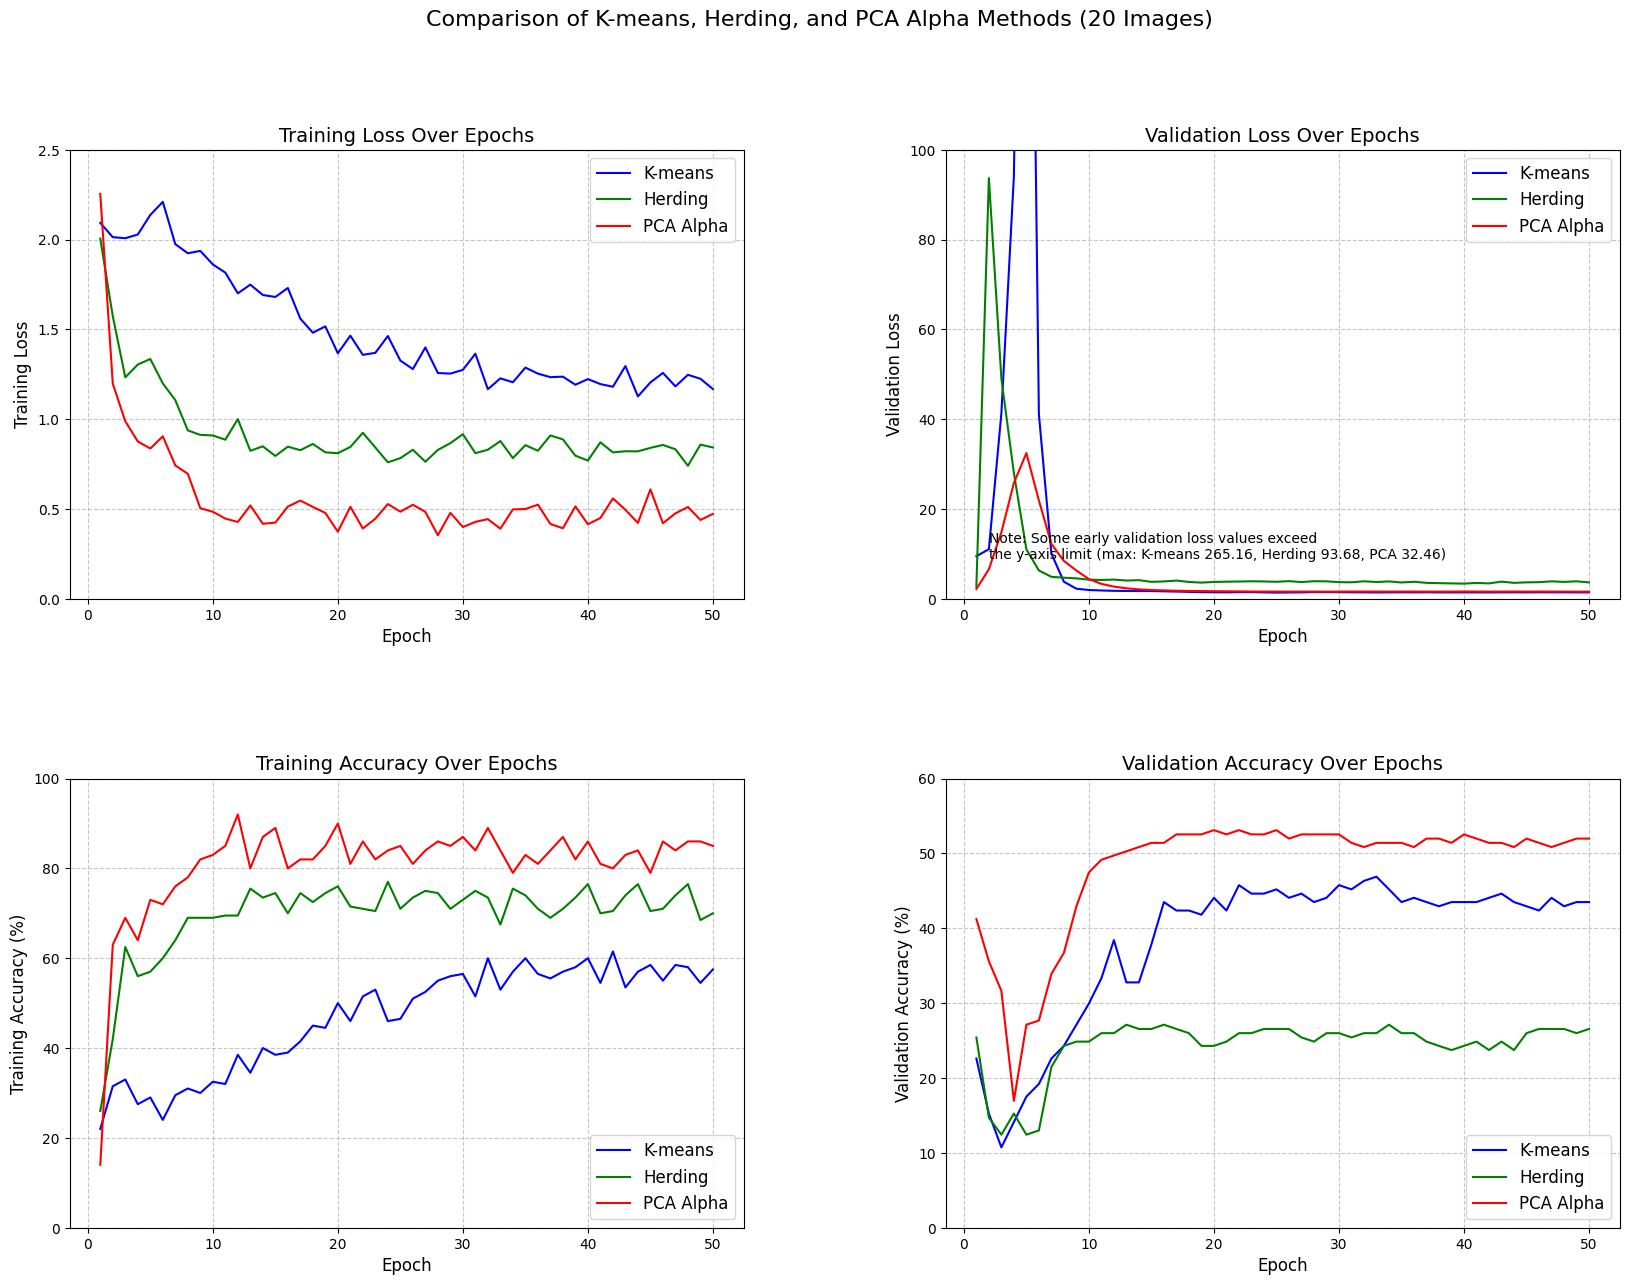

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for k-means
kmeans_epochs = np.arange(1, 51)
kmeans_train_loss = [2.0929, 2.0132, 2.0075, 2.0281, 2.1370, 2.2098, 1.9744, 1.9237, 1.9370, 1.8616,
                    1.8161, 1.7006, 1.7492, 1.6915, 1.6805, 1.7305, 1.5598, 1.4814, 1.5168, 1.3671,
                    1.4648, 1.3583, 1.3695, 1.4631, 1.3265, 1.2789, 1.3995, 1.2571, 1.2539, 1.2747,
                    1.3646, 1.1670, 1.2274, 1.2057, 1.2874, 1.2538, 1.2340, 1.2369, 1.1919, 1.2234,
                    1.1956, 1.1806, 1.2961, 1.1271, 1.2048, 1.2578, 1.1830, 1.2472, 1.2251, 1.1679]
kmeans_train_acc = [22.00, 31.50, 33.00, 27.50, 29.00, 24.00, 29.50, 31.00, 30.00, 32.50,
                   32.00, 38.50, 34.50, 40.00, 38.50, 39.00, 41.50, 45.00, 44.50, 50.00,
                   46.00, 51.50, 53.00, 46.00, 46.50, 51.00, 52.50, 55.00, 56.00, 56.50,
                   51.50, 60.00, 53.00, 57.00, 60.00, 56.50, 55.50, 57.00, 58.00, 60.00,
                   54.50, 61.50, 53.50, 57.00, 58.50, 55.00, 58.50, 58.00, 54.50, 57.50]
kmeans_val_loss = [9.5001, 11.0615, 41.2936, 94.0753, 265.1558, 41.1124, 10.0729, 3.8170, 2.2681, 1.9791,
                  1.8728, 1.7983, 1.7609, 1.7466, 1.7392, 1.6852, 1.6318, 1.5640, 1.4934, 1.4790,
                  1.4564, 1.4930, 1.5116, 1.4481, 1.3991, 1.4303, 1.4496, 1.5196, 1.5063, 1.4893,
                  1.4653, 1.4559, 1.4332, 1.4525, 1.4627, 1.4533, 1.4676, 1.4435, 1.4440, 1.4492,
                  1.4502, 1.4364, 1.4499, 1.4611, 1.4498, 1.4718, 1.4634, 1.4576, 1.4431, 1.4411]
kmeans_val_acc = [22.60, 15.25, 10.73, 14.12, 17.51, 19.21, 22.60, 24.29, 27.12, 29.94,
                 33.33, 38.42, 32.77, 32.77, 37.85, 43.50, 42.37, 42.37, 41.81, 44.07,
                 42.37, 45.76, 44.63, 44.63, 45.20, 44.07, 44.63, 43.50, 44.07, 45.76,
                 45.20, 46.33, 46.89, 45.20, 43.50, 44.07, 43.50, 42.94, 43.50, 43.50,
                 43.50, 44.07, 44.63, 43.50, 42.94, 42.37, 44.07, 42.94, 43.50, 43.50]

# Data for herding
herding_epochs = np.arange(1, 51)
herding_train_loss = [2.0052, 1.5733, 1.2331, 1.3043, 1.3352, 1.1994, 1.1064, 0.9376, 0.9129, 0.9096,
                     0.8860, 1.0005, 0.8242, 0.8490, 0.7955, 0.8473, 0.8276, 0.8624, 0.8157, 0.8110,
                     0.8455, 0.9245, 0.8425, 0.7600, 0.7833, 0.8300, 0.7633, 0.8291, 0.8668, 0.9165,
                     0.8111, 0.8302, 0.8785, 0.7837, 0.8557, 0.8246, 0.9096, 0.8877, 0.7969, 0.7698,
                     0.8715, 0.8154, 0.8217, 0.8211, 0.8405, 0.8567, 0.8329, 0.7409, 0.8588, 0.8429]
herding_train_acc = [26.00, 42.00, 62.50, 56.00, 57.00, 60.00, 64.00, 69.00, 69.00, 69.00,
                    69.50, 69.50, 75.50, 73.50, 74.50, 70.00, 74.50, 72.50, 74.50, 76.00,
                    71.50, 71.00, 70.50, 77.00, 71.00, 73.50, 75.00, 74.50, 71.00, 73.00,
                    75.00, 73.50, 67.50, 75.50, 74.00, 71.00, 69.00, 71.00, 73.50, 76.50,
                    70.00, 70.50, 74.00, 76.50, 70.50, 71.00, 74.00, 76.50, 68.50, 70.00]
herding_val_loss = [2.7164, 93.6804, 49.0882, 28.0282, 11.0291, 6.3251, 4.9106, 4.7153, 4.5713, 4.2833,
                   4.2078, 4.2988, 4.0836, 4.1690, 3.7926, 3.8890, 4.0763, 3.7682, 3.6255, 3.7727,
                   3.8320, 3.8662, 3.9206, 3.8815, 3.8081, 3.9481, 3.7488, 3.9351, 3.9087, 3.7291,
                   3.6964, 3.9144, 3.7561, 3.8910, 3.6564, 3.8129, 3.5684, 3.5001, 3.4501, 3.3997,
                   3.5586, 3.4475, 3.8457, 3.5675, 3.6821, 3.7216, 3.9101, 3.7779, 3.9161, 3.6619]
herding_val_acc = [25.42, 14.69, 12.43, 15.25, 12.43, 12.99, 21.47, 24.29, 24.86, 24.86,
                  25.99, 25.99, 27.12, 26.55, 26.55, 27.12, 26.55, 25.99, 24.29, 24.29,
                  24.86, 25.99, 25.99, 26.55, 26.55, 26.55, 25.42, 24.86, 25.99, 25.99,
                  25.42, 25.99, 25.99, 27.12, 25.99, 25.99, 24.86, 24.29, 23.73, 24.29,
                  24.86, 23.73, 24.86, 23.73, 25.99, 26.55, 26.55, 26.55, 25.99, 26.55]

# Data for PCA alpha
pca_epochs = np.arange(1, 51)
pca_train_loss = [2.2541, 1.1980, 0.9885, 0.8763, 0.8369, 0.9050, 0.7430, 0.6962, 0.5046, 0.4849,
                 0.4469, 0.4282, 0.5199, 0.4183, 0.4244, 0.5139, 0.5471, 0.5121, 0.4782, 0.3740,
                 0.5125, 0.3916, 0.4463, 0.5278, 0.4855, 0.5238, 0.4843, 0.3541, 0.4789, 0.3999,
                 0.4288, 0.4439, 0.3906, 0.4982, 0.5001, 0.5245, 0.4170, 0.3930, 0.5149, 0.4155,
                 0.4504, 0.5595, 0.4958, 0.4229, 0.6095, 0.4212, 0.4761, 0.5115, 0.4393, 0.4732]
pca_train_acc = [14.00, 63.00, 69.00, 64.00, 73.00, 72.00, 76.00, 78.00, 82.00, 83.00,
                85.00, 92.00, 80.00, 87.00, 89.00, 80.00, 82.00, 82.00, 85.00, 90.00,
                81.00, 86.00, 82.00, 84.00, 85.00, 81.00, 84.00, 86.00, 85.00, 87.00,
                84.00, 89.00, 84.00, 79.00, 83.00, 81.00, 84.00, 87.00, 82.00, 86.00,
                81.00, 80.00, 83.00, 84.00, 79.00, 86.00, 84.00, 86.00, 86.00, 85.00]
pca_val_loss = [2.1958, 6.5999, 14.8094, 25.7951, 32.4626, 21.9057, 12.2344, 8.4500, 6.3131, 4.4065,
               3.3482, 2.7281, 2.3595, 2.1171, 1.9706, 1.8938, 1.8124, 1.7624, 1.7398, 1.7077,
               1.6855, 1.6736, 1.6394, 1.6219, 1.6250, 1.6157, 1.6222, 1.6197, 1.6060, 1.6172,
               1.6352, 1.6287, 1.6289, 1.6177, 1.6233, 1.6298, 1.6131, 1.6084, 1.6238, 1.6398,
               1.6269, 1.6191, 1.6138, 1.6329, 1.6217, 1.6310, 1.6206, 1.6193, 1.6062, 1.5994]
pca_val_acc = [41.24, 35.59, 31.64, 16.95, 27.12, 27.68, 33.90, 36.72, 42.94, 47.46,
              49.15, 49.72, 50.28, 50.85, 51.41, 51.41, 52.54, 52.54, 52.54, 53.11,
              52.54, 53.11, 52.54, 52.54, 53.11, 51.98, 52.54, 52.54, 52.54, 52.54,
              51.41, 50.85, 51.41, 51.41, 51.41, 50.85, 51.98, 51.98, 51.41, 52.54,
              51.98, 51.41, 51.41, 50.85, 51.98, 51.41, 50.85, 51.41, 51.98, 51.98]

# Set up the figure and axes for plotting
plt.figure(figsize=(20, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot Training Loss
plt.subplot(2, 2, 1)
plt.plot(kmeans_epochs, kmeans_train_loss, 'b-', label='K-means')
plt.plot(herding_epochs, herding_train_loss, 'g-', label='Herding')
plt.plot(pca_epochs, pca_train_loss, 'r-', label='PCA Alpha')
plt.title('Training Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(0, 2.5)  # Adjust y-axis for better visibility

# Plot Validation Loss
plt.subplot(2, 2, 2)
plt.plot(kmeans_epochs, kmeans_val_loss, 'b-', label='K-means')
plt.plot(herding_epochs, herding_val_loss, 'g-', label='Herding')
plt.plot(pca_epochs, pca_val_loss, 'r-', label='PCA Alpha')
plt.title('Validation Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(0, 100)  # Limiting y-axis to focus on the stable region
plt.text(2, 9, "Note: Some early validation loss values exceed\nthe y-axis limit (max: K-means 265.16, Herding 93.68, PCA 32.46)")

# Plot Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(kmeans_epochs, kmeans_train_acc, 'b-', label='K-means')
plt.plot(herding_epochs, herding_train_acc, 'g-', label='Herding')
plt.plot(pca_epochs, pca_train_acc, 'r-', label='PCA Alpha')
plt.title('Training Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Accuracy (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(0, 100)

# Plot Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(kmeans_epochs, kmeans_val_acc, 'b-', label='K-means')
plt.plot(herding_epochs, herding_val_acc, 'g-', label='Herding')
plt.plot(pca_epochs, pca_val_acc, 'r-', label='PCA Alpha')
plt.title('Validation Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(0, 60)

plt.suptitle('Comparison of K-means, Herding, and PCA Alpha Methods (20 Images)', fontsize=16)

# Save the figure
plt.savefig('training_metrics_comparison.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

NameError: name 'herding_min' is not defined

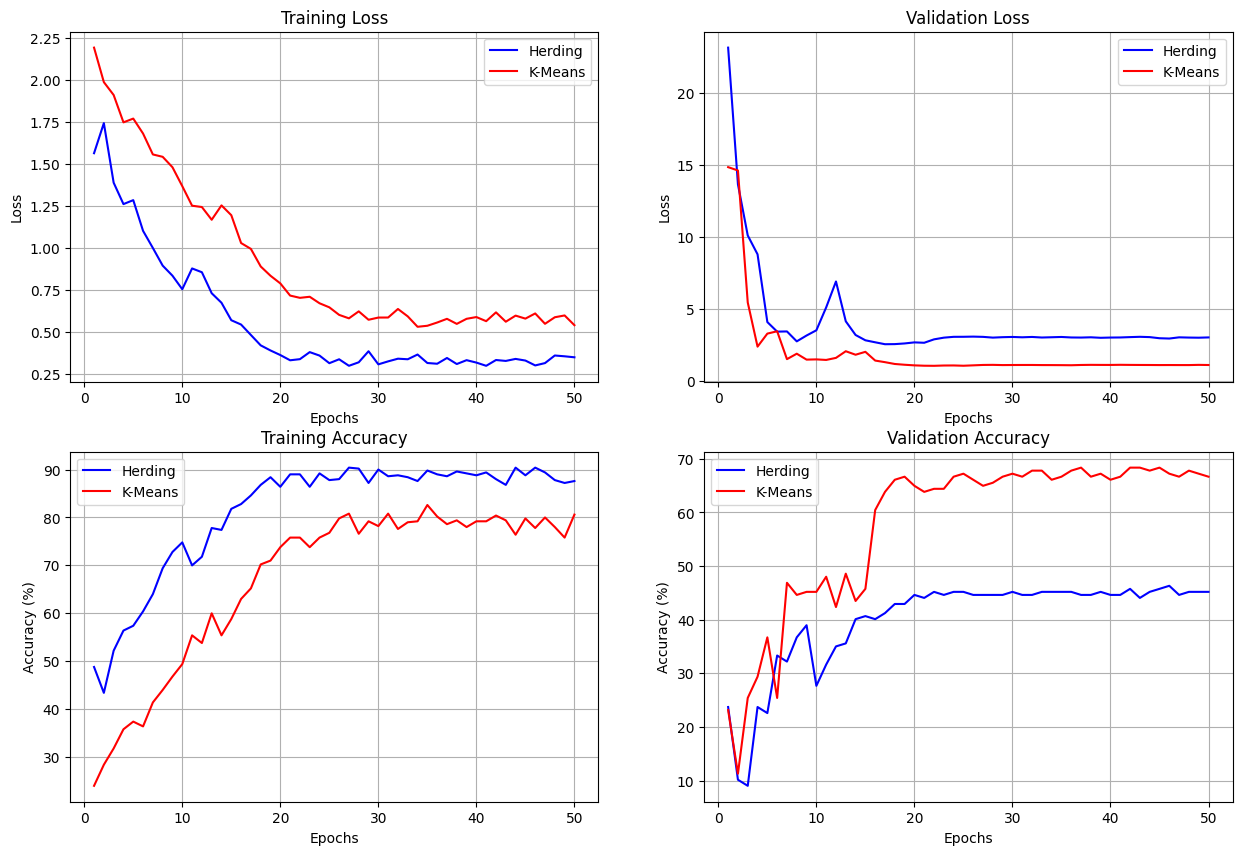

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data for herding method
herding_epochs = list(range(1, 51))
herding_train_loss = [1.5619, 1.7409, 1.3865, 1.2591, 1.2826, 1.0998, 0.9979, 0.8929, 0.8328, 0.7523,
                      0.8761, 0.8535, 0.7285, 0.6718, 0.5679, 0.5420, 0.4799, 0.4182, 0.3878, 0.3606,
                      0.3294, 0.3361, 0.3780, 0.3574, 0.3121, 0.3354, 0.2966, 0.3175, 0.3832, 0.3052,
                      0.3230, 0.3389, 0.3355, 0.3637, 0.3132, 0.3088, 0.3431, 0.3071, 0.3301, 0.3157,
                      0.2965, 0.3310, 0.3256, 0.3376, 0.3278, 0.2988, 0.3127, 0.3579, 0.3531, 0.3472]

herding_train_acc = [48.80, 43.40, 52.20, 56.40, 57.40, 60.40, 64.00, 69.40, 72.80, 74.80,
                     70.00, 71.80, 77.80, 77.40, 81.80, 82.80, 84.60, 86.80, 88.40, 86.40,
                     89.00, 89.00, 86.40, 89.20, 87.80, 88.00, 90.40, 90.20, 87.20, 90.00,
                     88.60, 88.80, 88.40, 87.60, 89.80, 89.00, 88.60, 89.60, 89.20, 88.80,
                     89.40, 88.00, 86.80, 90.40, 88.80, 90.40, 89.40, 87.80, 87.20, 87.60]

herding_val_loss = [23.1145, 13.6358, 10.0926, 8.7834, 4.0865, 3.4227, 3.4362, 2.7483, 3.1534, 3.5161,
                    5.1024, 6.9003, 4.1384, 3.1900, 2.8220, 2.6835, 2.5502, 2.5571, 2.6036, 2.6772,
                    2.6508, 2.8870, 3.0049, 3.0624, 3.0652, 3.0771, 3.0600, 3.0083, 3.0377, 3.0541,
                    3.0302, 3.0540, 3.0150, 3.0334, 3.0529, 3.0179, 3.0115, 3.0297, 2.9955, 3.0122,
                    3.0185, 3.0429, 3.0642, 3.0430, 2.9650, 2.9442, 3.0272, 3.0109, 3.0021, 3.0211]

herding_val_acc = [23.73, 10.17, 9.04, 23.73, 22.60, 33.33, 32.20, 36.72, 38.98, 27.68,
                   31.64, 35.03, 35.59, 40.11, 40.68, 40.11, 41.24, 42.94, 42.94, 44.63,
                   44.07, 45.20, 44.63, 45.20, 45.20, 44.63, 44.63, 44.63, 44.63, 45.20,
                   44.63, 44.63, 45.20, 45.20, 45.20, 45.20, 44.63, 44.63, 45.20, 44.63,
                   44.63, 45.76, 44.07, 45.20, 45.76, 46.33, 44.63, 45.20, 45.20, 45.20]

# Data for k-means method
kmeans_epochs = list(range(1, 51))
kmeans_train_loss = [2.1904, 1.9851, 1.9084, 1.7457, 1.7680, 1.6789, 1.5546, 1.5405, 1.4784, 1.3659,
                     1.2495, 1.2416, 1.1659, 1.2514, 1.1930, 1.0272, 0.9924, 0.8878, 0.8325, 0.7871,
                     0.7146, 0.7011, 0.7075, 0.6688, 0.6446, 0.5997, 0.5791, 0.6206, 0.5706, 0.5837,
                     0.5840, 0.6348, 0.5907, 0.5288, 0.5349, 0.5542, 0.5762, 0.5461, 0.5763, 0.5867,
                     0.5622, 0.6146, 0.5590, 0.5953, 0.5774, 0.6082, 0.5466, 0.5855, 0.5963, 0.5383]

kmeans_train_acc = [24.00, 28.40, 31.80, 35.80, 37.40, 36.40, 41.40, 44.00, 46.80, 49.40,
                    55.40, 53.80, 60.00, 55.40, 58.80, 63.00, 65.20, 70.20, 71.00, 73.80,
                    75.80, 75.80, 73.80, 75.80, 76.80, 79.80, 80.80, 76.60, 79.20, 78.20,
                    80.80, 77.60, 79.00, 79.20, 82.60, 80.20, 78.60, 79.40, 78.00, 79.20,
                    79.20, 80.40, 79.40, 76.40, 79.80, 77.80, 80.00, 78.00, 75.80, 80.60]

kmeans_val_loss = [14.8281, 14.5959, 5.4450, 2.3820, 3.2855, 3.4478, 1.5153, 1.8918, 1.4819, 1.4982,
                   1.4601, 1.6026, 2.0638, 1.8210, 2.0227, 1.4165, 1.3054, 1.1797, 1.1266, 1.0835,
                   1.0593, 1.0528, 1.0736, 1.0778, 1.0577, 1.0848, 1.1126, 1.1189, 1.1037, 1.1086,
                   1.1110, 1.1110, 1.1041, 1.1025, 1.0990, 1.0924, 1.1111, 1.1193, 1.1151, 1.1133,
                   1.1225, 1.1158, 1.1117, 1.1092, 1.1046, 1.1067, 1.1041, 1.1038, 1.1183, 1.1084]

kmeans_val_acc = [23.16, 11.30, 25.42, 29.38, 36.72, 25.42, 46.89, 44.63, 45.20, 45.20,
                  48.02, 42.37, 48.59, 43.50, 45.76, 60.45, 63.84, 66.10, 66.67, 64.97,
                  63.84, 64.41, 64.41, 66.67, 67.23, 66.10, 64.97, 65.54, 66.67, 67.23,
                  66.67, 67.80, 67.80, 66.10, 66.67, 67.80, 68.36, 66.67, 67.23, 66.10,
                  66.67, 68.36, 68.36, 67.80, 68.36, 67.23, 66.67, 67.80, 67.23, 66.67]

# Create figure with subplots
plt.figure(figsize=(15, 10))

# Plot 1: Training Loss
plt.subplot(2, 2, 1)
plt.plot(herding_epochs, herding_train_loss, 'b-', label='Herding')
plt.plot(kmeans_epochs, kmeans_train_loss, 'r-', label='K-Means')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation Loss
plt.subplot(2, 2, 2)
plt.plot(herding_epochs, herding_val_loss, 'b-', label='Herding')
plt.plot(kmeans_epochs, kmeans_val_loss, 'r-', label='K-Means')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 3: Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(herding_epochs, herding_train_acc, 'b-', label='Herding')
plt.plot(kmeans_epochs, kmeans_train_acc, 'r-', label='K-Means')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot 4: Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(herding_epochs, herding_val_acc, 'b-', label='Herding')
plt.plot(kmeans_epochs, kmeans_val_acc, 'r-', label='K-Means')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Find optimal validation loss for both methods
herding_min_val_loss_idx = np.argmin(herding_val_loss)
herding_min_val_loss = herding_val_loss[herding_min_val_loss_idx]
herding_min_val_loss_epoch = herding_epochs[herding_min_val_loss_idx]

kmeans_min_val_loss_idx = np.argmin(kmeans_val_loss)
kmeans_min_val_loss = kmeans_val_loss[kmeans_min_val_loss_idx]
kmeans_min_val_loss_epoch = kmeans_epochs[kmeans_min_val_loss_idx]

# Mark optimal validation loss points on plot 2
plt.subplot(2, 2, 2)
plt.plot(herding_min)